In [ ]:
!pip install texttable
!pip install rasterio


In [ ]:
# Libraries
import ee
import geemap
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.exposure import match_histograms
import time
import texttable as tt
import rasterio
from rasterio.plot import reshape_as_raster

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


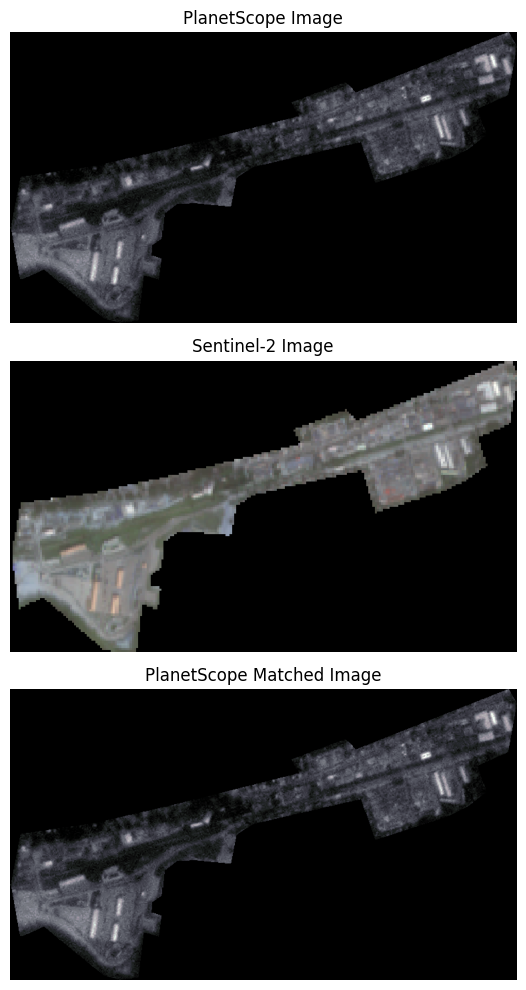

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import match_histograms

# Function for min-max normalization
def normalize_band(band):
    return (((band - np.amin(band)) / (np.amax(band) - np.amin(band))) * 255).astype(np.uint8)

# Directory and file paths
out_dir = '/content/drive/My Drive/fuse'

# PlanetScope bands
pla_files = ['matched_for_fusion_B2.tif', 'matched_for_fusion_B3.tif', 'matched_for_fusion_B4.tif']
additional_pla_files = ['band_4.tif', 'band_5.tif', 'band_6.tif', 'band_7.tif', 'band_8.tif']

# Sentinel2 bands
sentinel_files = ['B2.tif', 'B3.tif', 'B4.tif']

# Reading PlanetScope bands
Pla_bands = [rasterio.open(os.path.join(out_dir, file)).read(1) for file in pla_files]
Pla_additional_bands = [rasterio.open(os.path.join(out_dir, file)).read(1) for file in additional_pla_files]

# Reading Sentinel-2 bands
S2_bands = [rasterio.open(os.path.join(out_dir, file)).read(1) for file in sentinel_files]

# Perform histogram matching from PlanetScope to Sentinel-2 for RGB bands
matched_Pla_to_S2 = [match_histograms(Pla_bands[i], S2_bands[i]) for i in range(len(Pla_bands))]

# Normalize the RGB and additional bands
Pla_bands_norm = [normalize_band(band) for band in Pla_bands]
Pla_additional_bands_norm = [normalize_band(band) for band in Pla_additional_bands]
S2_bands_norm = [normalize_band(band) for band in S2_bands]
matched_Pla_to_S2_norm = [normalize_band(band) for band in matched_Pla_to_S2]

# Create 3-channel images
Pla_xs = np.stack(Pla_bands_norm, axis=2)
S2_xs = np.stack(S2_bands_norm, axis=2)
matched_Pla_to_S2_uint8 = np.stack(matched_Pla_to_S2_norm, axis=2)

# Plotting
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(13, 10))

ax0.imshow(Pla_xs)
ax0.set_title("PlanetScope Image")
ax0.axis('off')

ax1.imshow(S2_xs)
ax1.set_title("Sentinel-2 Image")
ax1.axis('off')

ax2.imshow(matched_Pla_to_S2_uint8)
ax2.set_title("PlanetScope Matched Image")
ax2.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Base filter used to degradate the images
base_filter = 1/256 * np.array([[1, 4, 6, 4 ,1],
[4, 16, 24, 16, 4],
[6, 24, 36, 24, 6],
[4, 16, 24, 16, 4],
[1, 4, 6, 4 ,1]])


def obtain_filter(n=0,base_filter=base_filter):
    filter = []
    for row in base_filter:
        filter.append(put_n_zeros(row, n))
    return put_n_rows_of_zeros(filter,n)

'''
    This method adds n zeros between each element of the array
'''
def put_n_zeros(row, n):
    result = [row[0]]
    for i in range(1,len(row)):
        result += [0]*n + [row[i]]
    return result

'''
    This method adds n rows of zeros between each element of the matrix
'''
def put_n_rows_of_zeros(matrix, n):
    zeros = np.zeros((n,len(matrix[0])))
    result = [matrix[0]]
    for i in range(1,len(matrix)):
        result = np.concatenate((result, zeros, [matrix[i]]))
    return result

In [ ]:
'''
Input:
    arr1 -> Multispectral band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    coefs -> A list containing the wavelet coefficients of each degradation
    current_degradation -> Degradated band after applying levels - init_level filters
'''
def twa(arr1, levels, init_level=0):
    # Init variables
    previous_degradation = np.array(arr1)
    current_degradation = []
    coefs = np.empty([arr1.shape[0],arr1.shape[1],0])
    # Apply levels - init_level degradations
    for level in range(init_level, levels):
        # Obtain the filter for each level
        a_trous_filter = obtain_filter(level)
        # Convolution between the image and the filter
        current_degradation = signal.convolve2d(previous_degradation, a_trous_filter, mode='same')
        # Obtain the wavelet coefficients
        current_coef = previous_degradation-current_degradation
        current_coef = np.expand_dims(current_coef, axis=2)
        coefs = np.append(coefs, current_coef, axis=2)
        previous_degradation = current_degradation
    return coefs, current_degradation

'''
Input:
    L8_xs -> Planetscope image, the image to degradate
    S2_xs -> Sentinel 2 image, the image containing the spatial details
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_twa_multiband(L8_xs, S2_xs, levels, init_level=0):
    s_time = time.time()
    # Initialize image
    fused_img = np.empty([L8_xs.shape[0], L8_xs.shape[1], 0])
    # If the multispectral image has 3 bands or more, we start the fusion
    if L8_xs.ndim > 2:
        for nBand in range(L8_xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_twa_single_band(L8_xs[:,:,nBand], S2_xs[:,:,nBand], levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        fused_img
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image (To obtain the wavelet coefficients)
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_twa_single_band(xs, pan, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    fused_band = f_xs + coef_pan
    return fused_band

In [ ]:
'''
Input:
    L8_xs -> Multispectral image, the image to degradate
    S2_xs -> Panchromatic image, the image containing the spatial details
    alpha -> Weight of the spatial resolution for each band
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_wtwa_multiband(L8_xs, S2_xs, alpha, levels, init_level=0):
    s_time = time.time()
    # If we receive a int instead of a vector of n-bands weights, we apply the same weight to each band
    if type(alpha) in (float,int):
        alpha = [alpha]*L8_xs.shape[2]
    # Initialize image
    fused_img = np.empty([L8_xs.shape[0], L8_xs.shape[1], 0])
    # If the multispectral image has 3 bands or more, we start the fusion
    if L8_xs.ndim > 2:
        for nBand in range(L8_xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_wtwa_single_band(L8_xs[:,:,nBand], S2_xs[:,:,nBand], alpha[nBand], levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image (To obtain the wavelet coefficients)
    alpha -> Weight of the spatial resolution
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_wtwa_single_band(xs, pan, alpha, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving " + str(alpha) + " to the weight of the spatial resolution")
    fused_band = f_xs + alpha*coef_pan
    return fused_band

In [ ]:
'''
Input:
    L8_xs -> Multispectral image, the image to degradate
    S2_xs -> Panchromatic image, the image containing the spatial details
    radius -> Neighborhood radius
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_img -> Fused image
'''
def fusion_ftwa_multiband(L8_xs, S2_xs, radius, levels, init_level=0):
    # Inicializo la imagen
    s_time = time.time()
    fused_img = np.empty([L8_xs.shape[0], L8_xs.shape[1], 0])
    # If the multispectral image has 3 bands or more, we start the fusion
    if L8_xs.ndim > 2:
        for nBand in range(L8_xs.shape[2]):
            print("---------------------------------------------------")
            print("Fusing band " + str(nBand) + " of the multispectral image")
            img_nBand = fusion_ftwa_single_band(L8_xs[:,:,nBand], S2_xs[:,:,nBand], radius, levels)
            img_nBand = np.expand_dims(img_nBand, axis=2)
            fused_img = np.append(fused_img, img_nBand, axis=2)
            print("Fused band " + str(nBand) + " of the multispectral image")
            print("---- %s seconds ------" % (time.time()-s_time))
            print("---------------------------------------------------")
    else:
        print("The first argument must have the shape (x,y,z), received: " + str(xs.shape))
        return None
    return fused_img

'''
Input:
    xs -> A single band of the multispectral image
    pan -> Panchromatic image (To obtain the wavelet coefficients)
    radius -> Radius of the neighborhood
    levels -> Degradation levels
    init_level -> Start level, 1 by default
Output:
    fused_band -> Fused band
'''
def fusion_ftwa_single_band(xs, pan, radius, levels, init_level=0):
    # Apply wavelet a trous to both bands, obtain the degradated band of the multiespectral band,
    # and the wavelet coefficients of the panchromatic image
    _, f_xs = twa(xs, levels)
    c_pan, _ = twa(pan, levels)
    # Add the coefficients
    coef_pan = np.sum(c_pan, axis=2)
    # Obtain the fused band
    print("Fusing the band of the multispectral image giving with " + str(radius) + " as the radius of the entropy")
    merged_img = f_xs + applyEntropy(xs, radius)*coef_pan
    return merged_img

def applyEntropy(xs, radius):
    img = entropy(xs, disk(radius))
    # Normalize values to 1 as max value
    img = img/np.amax(img)
    return img

In [ ]:
# Create 3-channel images
Pla_xs = np.stack(Pla_bands_norm, axis=2)
S2_xs = np.stack(S2_bands_norm, axis=2)
matched_Pla_to_S2_uint8 = np.stack(matched_Pla_to_S2_norm, axis=2)

# Convert to NumPy arrays
img_S2_xs = np.array(S2_xs)
matched_Pla_to_S2 = np.array(matched_Pla_to_S2_uint8)

In [ ]:
img_fus = fusion_twa_multiband(img_S2_xs, matched_Pla_to_S2, 5)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fused band 0 of the multispectral image
---- 2.0763516426086426 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fused band 1 of the multispectral image
---- 4.150373935699463 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fused band 2 of the multispectral image
---- 6.6954028606414795 seconds ------
---------------------------------------------------


In [ ]:
# Weighted TWAT fusion with 5 cicles (Weight range -> [0,2])
img_fus = fusion_wtwa_multiband(img_S2_xs, matched_Pla_to_S2, 1.5, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 0 of the multispectral image
---- 2.50484299659729 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 1 of the multispectral image
---- 4.539094924926758 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fusing the band of the multispectral image giving 1.5 to the weight of the spatial resolution
Fused band 2 of the multispectral image
---- 6.589656829833984 seconds ------
---------------------------------------------------


In [ ]:
# FractalxTWAT fusion with 5 cicles (the third parameter is the entropy radius)
img_fus = fusion_ftwa_multiband(img_S2_xs, matched_Pla_to_S2, 10, 5)
img_fus = img_fus.astype(np.uint16)

---------------------------------------------------
Fusing band 0 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy
Fused band 0 of the multispectral image
---- 2.350672721862793 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 1 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy
Fused band 1 of the multispectral image
---- 4.874993801116943 seconds ------
---------------------------------------------------
---------------------------------------------------
Fusing band 2 of the multispectral image
Fusing the band of the multispectral image giving with 10 as the radius of the entropy
Fused band 2 of the multispectral image
---- 9.049719333648682 seconds ------
---------------------------------------------------


In [ ]:
img_fus[:,:,0] = ((img_fus[:,:,0]-np.amin(img_fus[:,:,0]))/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amax(img_S2_xs[:,:,2]) + ((np.amax(img_fus[:,:,0]) - img_fus[:,:,0])/(np.amax(img_fus[:,:,0])-np.amin(img_fus[:,:,0])))*np.amin(img_S2_xs[:,:,2])
img_fus[:,:,1] = ((img_fus[:,:,1]-np.amin(img_fus[:,:,1]))/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amax(img_S2_xs[:,:,1]) + ((np.amax(img_fus[:,:,1]) - img_fus[:,:,1])/(np.amax(img_fus[:,:,1])-np.amin(img_fus[:,:,1])))*np.amin(img_S2_xs[:,:,1])
img_fus[:,:,2] = ((img_fus[:,:,2]-np.amin(img_fus[:,:,2]))/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amax(img_S2_xs[:,:,0]) + ((np.amax(img_fus[:,:,2]) - img_fus[:,:,2])/(np.amax(img_fus[:,:,2])-np.amin(img_fus[:,:,2])))*np.amin(img_S2_xs[:,:,0])

img_fus = img_fus.astype(np.uint16)
print('Completed normalization to the multispectral image values')

Completed normalization to the multispectral image values


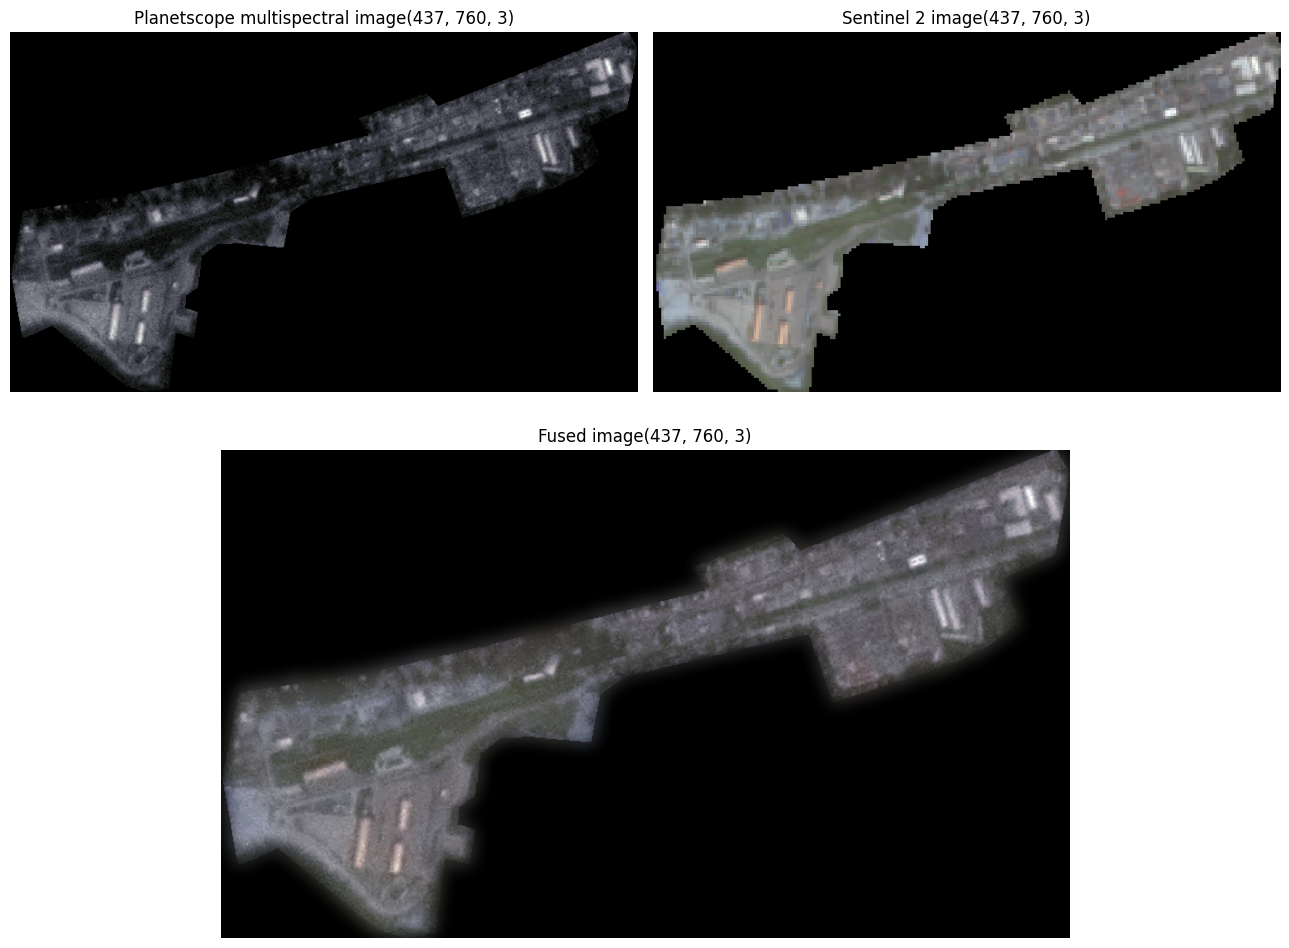

In [ ]:
# Fused image normalization
vis_fus = np.copy(img_fus)
vis_fus[:,:,0] = ((vis_fus[:,:,0]-np.amin(vis_fus[:,:,0]))/(np.amax(vis_fus[:,:,0])-np.amin(vis_fus[:,:,0])))*255
vis_fus[:,:,1] = ((vis_fus[:,:,1]-np.amin(vis_fus[:,:,1]))/(np.amax(vis_fus[:,:,1])-np.amin(vis_fus[:,:,1])))*255
vis_fus[:,:,2] = ((vis_fus[:,:,2]-np.amin(vis_fus[:,:,2]))/(np.amax(vis_fus[:,:,2])-np.amin(vis_fus[:,:,2])))*255
vis_fus = vis_fus.astype(int)

# Container creation, to fit the plots, with gridspec layout from matplotlib
fig = plt.figure(figsize=(13, 10))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Add the Planetscope image
ax0 = fig.add_subplot(spec[0,0])
ax0.imshow(Pla_xs)
ax0.set_title("Planetscope multispectral image" + str(Pla_xs.shape))
ax0.axis('off')

# Add the Sentinel 2 image
ax1 = fig.add_subplot(spec[0,1])
ax1.imshow(S2_xs)
ax1.set_title("Sentinel 2 image"  + str(S2_xs.shape))
ax1.axis('off')

# Add the fused image
ax2 = fig.add_subplot(spec[1,:])
ax2.imshow(vis_fus)
ax2.set_title("Fused image" + str(img_fus.shape))
ax2.axis('off')

plt.tight_layout()

In [ ]:
out_dir = '/content/drive/My Drive/fuse/result'

In [ ]:
# Save PlanetScope bands
for i, file in enumerate(pla_files):
    with rasterio.open(os.path.join(out_dir, 'Saved_PlanetScope_' + file), 'w', driver='GTiff',
                       height=Pla_bands[i].shape[0],
                       width=Pla_bands[i].shape[1], count=1, dtype=Pla_bands[i].dtype,
                       crs='+proj=latlong') as dst:
        dst.write(Pla_bands[i], 1)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [ ]:
# Save Sentinel-2 bands
for i, file in enumerate(sentinel_files):
    with rasterio.open(os.path.join(out_dir, 'Saved_Sentinel2_' + file), 'w', driver='GTiff',
                       height=S2_bands[i].shape[0],
                       width=S2_bands[i].shape[1], count=1, dtype=S2_bands[i].dtype,
                       crs='+proj=latlong') as dst:
        dst.write(S2_bands[i], 1)


In [ ]:
# Save the fused image
with rasterio.open(os.path.join(out_dir, 'Fused_Image.tif'), 'w', driver='GTiff',
                   height=img_fus.shape[0],
                   width=img_fus.shape[1], count=3, dtype=img_fus.dtype,
                   crs='+proj=latlong') as dst:
    for i in range(img_fus.shape[2]):
        dst.write(img_fus[:,:,i], i+1)


In [ ]:
with rasterio.open(os.path.join(out_dir, 'Saved_PlanetScope_Multispectral.tif'), 'w', driver='GTiff',
                   height=Pla_bands[0].shape[0],
                   width=Pla_bands[0].shape[1], count=len(pla_files), dtype=Pla_bands[0].dtype,
                   crs='+proj=latlong') as dst:
    for i in range(len(pla_files)):
        dst.write(Pla_bands[i], i+1)


In [ ]:
with rasterio.open(os.path.join(out_dir, 'Saved_Sentinel2_Multispectral.tif'), 'w', driver='GTiff',
                   height=S2_bands[0].shape[0],
                   width=S2_bands[0].shape[1], count=len(sentinel_files), dtype=S2_bands[0].dtype,
                   crs='+proj=latlong') as dst:
    for i in range(len(sentinel_files)):
        dst.write(S2_bands[i], i+1)


In [ ]:
with rasterio.open(os.path.join(out_dir, 'Fused_Multispectral_Image.tif'), 'w', driver='GTiff',
                   height=img_fus.shape[0],
                   width=img_fus.shape[1], count=img_fus.shape[2], dtype=img_fus.dtype,
                   crs='+proj=latlong') as dst:
    for i in range(img_fus.shape[2]):
        dst.write(img_fus[:,:,i], i+1)


In [ ]:
def spectral_ERGAS(img_origND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_orig = np.empty(img_origND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    mean_img_orig = np.empty(n_band)
    mean_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_orig[:,:,i] = img_origND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_orig[i] = img_orig[:,:,i].mean()
        mean_img_fus[i] = img_fus[:,:,i].mean()

        # Diference between the multispectral image and the fused image
        dif_imgs[:,:,i] = img_orig[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_orig[i] - mean_img_fus[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_orig[i]**2)

    # Spectral ergas
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

In [ ]:
def spatial_ERGAS(img_panND, img_fusND, ratio, coef_rad, n_band):

    # Initialize variables
    img_panc = np.empty(img_fusND.shape)
    img_fus = np.empty(img_fusND.shape)
    dif_imgs = np.empty(img_fusND.shape)
    img_pan_hist = np.empty(img_fusND.shape)
    mean_img_pan = np.empty(n_band)
    mean_img_multi = np.empty(n_band) # multi es la imagen fusionada
    rmse_img_fus = np.empty(n_band)
    razon_img_fus = np.empty(n_band)
    std_imgs = np.empty(n_band)

    for i in range(n_band):
        # Digital image to radiance
        img_panc[:,:,i] = img_panND[:,:,i]*coef_rad[i]
        img_fus[:,:,i] = img_fusND[:,:,i]*coef_rad[i]

        # Mean value of the radiances per band
        mean_img_pan[i] = img_panc[:,:,i].mean()
        mean_img_multi[i] = img_fus[:,:,i].mean()

        # Histogram of the panchromatic image
        delta_media = mean_img_multi[i] - mean_img_pan[i]
        img_pan_hist[:,:,i] = img_panc[:,:,i] + delta_media

        # Mean value of the panchromatic image histogram
        mean_img_pan[i] = img_pan_hist[:,:,i].mean()

        # Diference between the panchromatic image and the fused image
        dif_imgs[:,:,i] = img_pan_hist[:,:,i] - img_fus[:,:,i]
        std_imgs[i] = np.std(dif_imgs[:,:,i])

        # RMSE of the band
        rmse_img_fus[i] = (mean_img_pan[i] - mean_img_multi[i])**2 + std_imgs[i]**2

        # Image ratio
        razon_img_fus[i] = rmse_img_fus[i]/(mean_img_pan[i]**2)

    # Spatial ERGAS
    return 100*(ratio**2)*math.sqrt(razon_img_fus.mean())

In [ ]:
# ERGAS
ERGAS_X = spectral_ERGAS(img_S2_xs, img_fus, 1/3, [1,1,1], 3)
ERGAS_S = spatial_ERGAS(matched_Pla_to_S2_uint8, img_fus, 1/3, [1,1,1], 3)

# Display ERGAS on a table
tab = tt.Texttable()
headings = ['Espectral ERGAS','Spatial ERGAS']
tab.header(headings)
tab.add_row((ERGAS_X, ERGAS_S))
print(tab.draw())

+-----------------+---------------+
| Espectral ERGAS | Spatial ERGAS |
+=================+===============+
| 4.926           | 6.679         |
+-----------------+---------------+
